In [1]:
# MSc Data Science Project: Data Ingestion, Preprocessing, Summary Statistics, Visualizations, Model training and evaluation
# Dataset: MovieLens (ratings.csv, movies.csv, tags.csv, links.csv)



#  Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


In [2]:

# Setting global aesthetics for seaborn
sns.set(style='whitegrid', palette='pastel', font_scale=1.1)

In [3]:

# Load the CSV datasets

# Upload files via the file upload tool in Colab before running this cell
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')
tags = pd.read_csv('tags.csv')
links = pd.read_csv('links.csv')

In [4]:

# Inspect the Data

print("Ratings Sample:\n", ratings.head())
print("Movies Sample:\n", movies.head())
print("Tags Sample:\n", tags.head())
print("Links Sample:\n", links.head())

Ratings Sample:
    userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
Movies Sample:
    movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
Tags Sample:
    userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotabl

In [5]:

# Preprocess the Data

# Convert timestamps to datetime format
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
tags['timestamp'] = pd.to_datetime(tags['timestamp'], unit='s')

# Check for missing values
print("\nMissing Values Summary:")
print(ratings.isnull().sum())
print(movies.isnull().sum())
print(tags.isnull().sum())
print(links.isnull().sum())

# Remove duplicate tags
tags.drop_duplicates(inplace=True)

# Merge ratings with movies for enriched analysis
ratings_movies = pd.merge(ratings, movies, on='movieId')


Missing Values Summary:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
movieId    0
title      0
genres     0
dtype: int64
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64
movieId    0
imdbId     0
tmdbId     8
dtype: int64


In [6]:

# Summary Statistics

# Basic rating distribution
print("\nRatings Summary:")
print(ratings['rating'].describe())

# Number of unique users and movies
print(f"\nNumber of unique users: {ratings['userId'].nunique()}")
print(f"Number of unique movies: {ratings['movieId'].nunique()}")

# Top 10 most rated movies
top_rated = ratings_movies['title'].value_counts().head(10)
print("\nTop 10 Most Rated Movies:\n", top_rated)



Ratings Summary:
count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

Number of unique users: 610
Number of unique movies: 9724

Top 10 Most Rated Movies:
 title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: count, dtype: int64


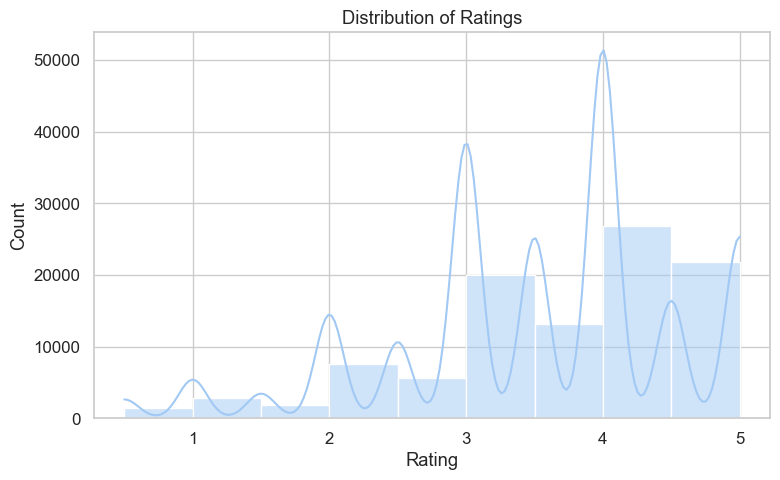

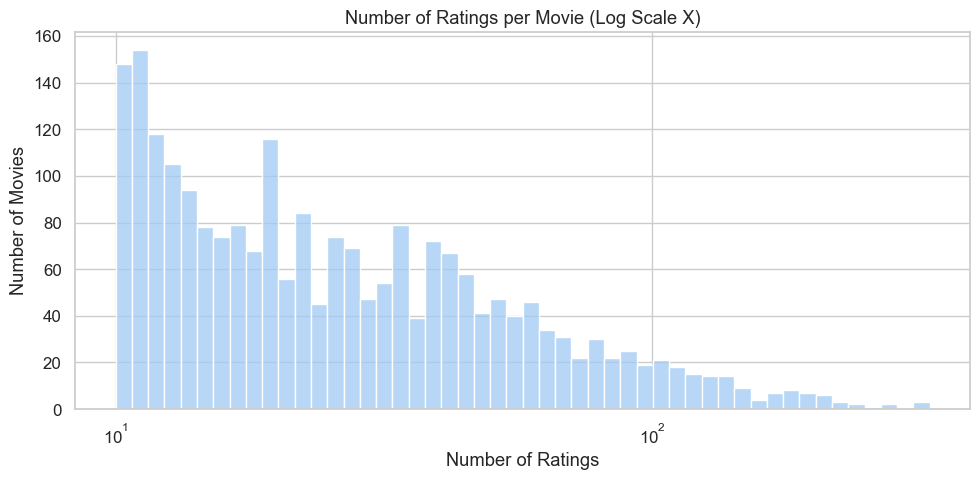

In [7]:

# Data Visualizations


#  Distribution of Ratings
plt.figure(figsize=(8, 5))
sns.histplot(ratings['rating'], bins=9, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

#  Number of Ratings per Movie
ratings_per_movie = ratings['movieId'].value_counts()

# Filter movies with at least 10 ratings
filtered = ratings_per_movie[ratings_per_movie >= 10]

plt.figure(figsize=(10, 5))
sns.histplot(filtered, bins=50, log_scale=True)
plt.title('Number of Ratings per Movie (Log Scale X)')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.tight_layout()
plt.show()


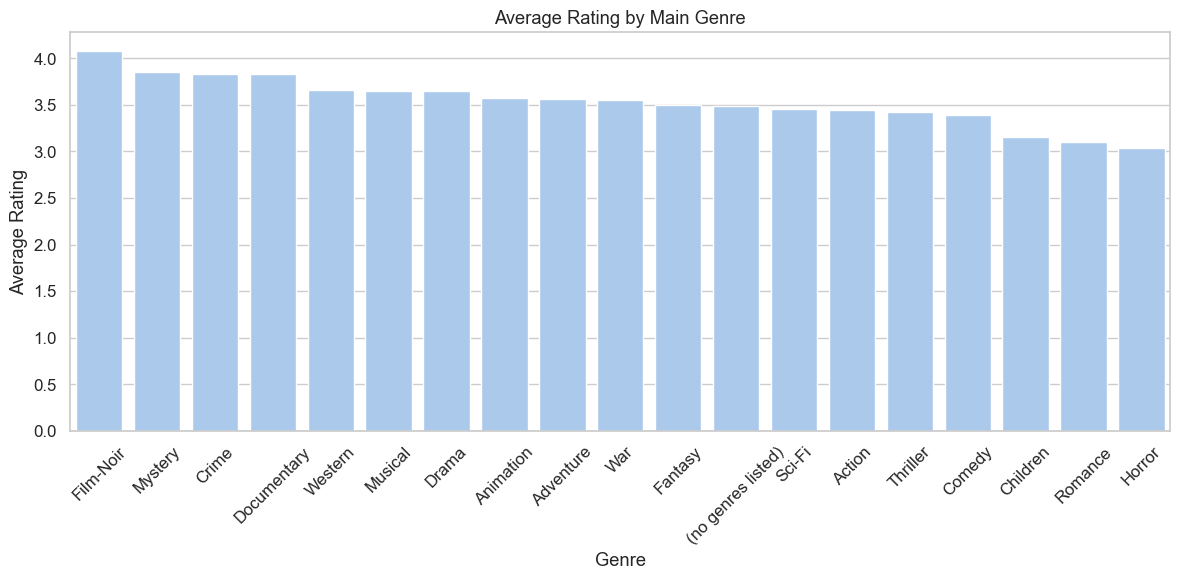

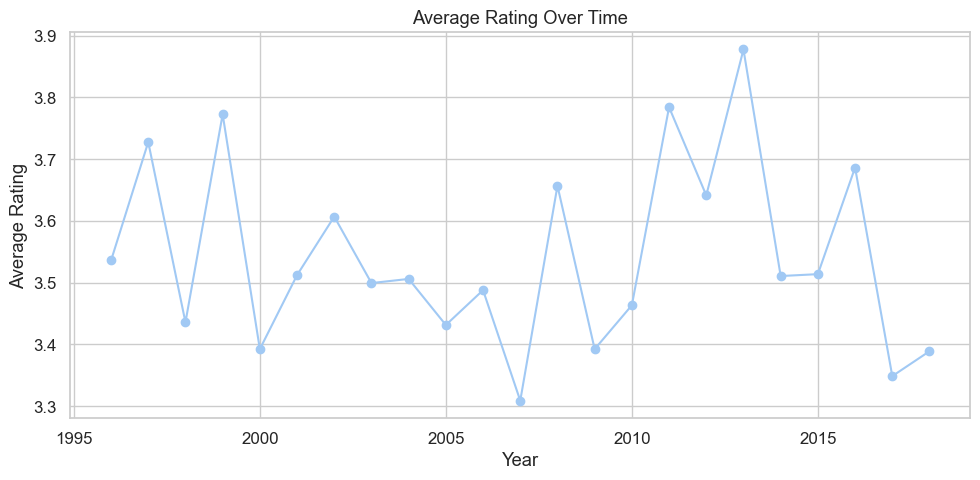

In [8]:
# Average Rating per Genre (First genre only)
movies['main_genre'] = movies['genres'].apply(lambda x: x.split('|')[0] if isinstance(x, str) else x)
ratings_movies = pd.merge(ratings, movies, on='movieId')
genre_rating = ratings_movies.groupby('main_genre')['rating'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_rating.index, y=genre_rating.values)
plt.title('Average Rating by Main Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Ratings Over Time
ratings['year'] = ratings['timestamp'].dt.year
ratings_by_year = ratings.groupby('year')['rating'].mean()

plt.figure(figsize=(10, 5))
ratings_by_year.plot(marker='o')
plt.title('Average Rating Over Time')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.grid(True)
plt.tight_layout()
plt.show()


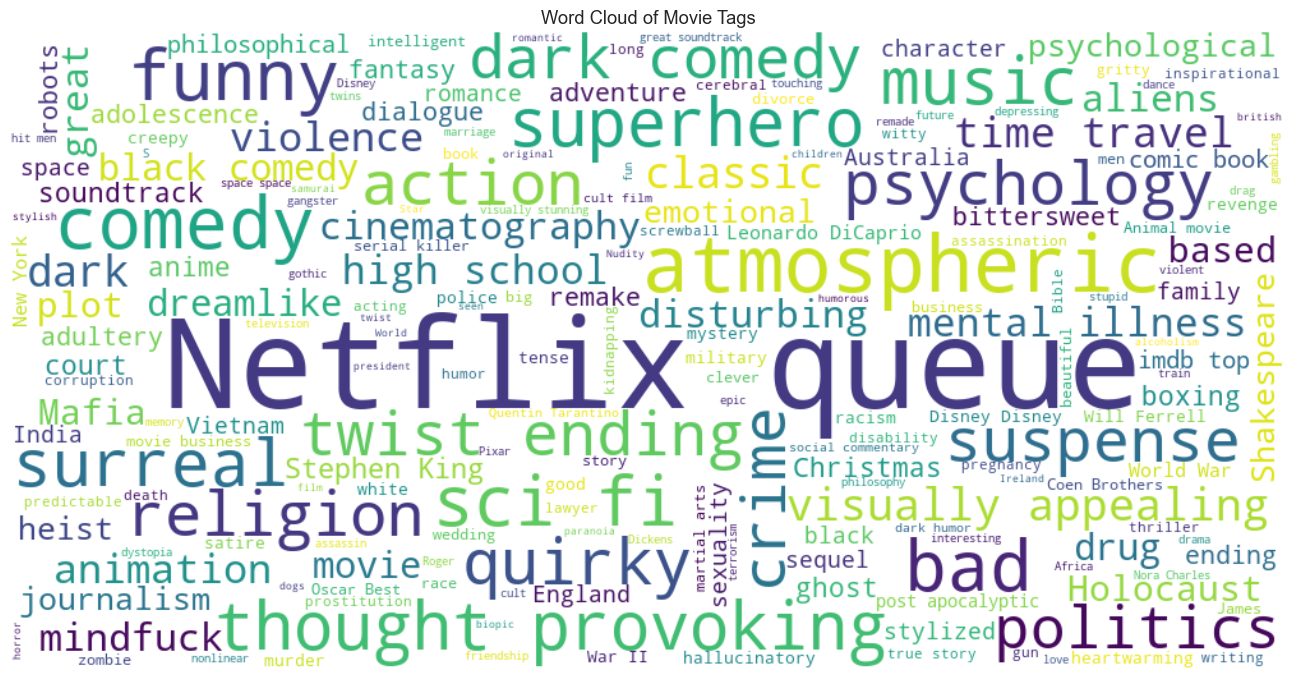

In [9]:
# Word Cloud from Tags
text = ' '.join(tags['tag'].dropna().astype(str).values)
wordcloud = WordCloud(width=1000, height=500, background_color='white', colormap='viridis').generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Movie Tags')
plt.tight_layout()
plt.show()

In [10]:
# Install kmodes if not already installed
!pip install kmodes

# Import necessary library for K-Modes clustering
from kmodes.kmodes import KModes



In [11]:
# Expand genres into individual rows per movie
movies_expanded = movies.copy()
movies_expanded['genres'] = movies_expanded['genres'].str.split('|')
movies_expanded = movies_expanded.explode('genres')

# Create one-hot encoded genre columns using crosstab (more reliable than pivot_table here)
genre_ohe = pd.crosstab(movies_expanded['movieId'], movies_expanded['genres'])

# Reset index to bring 'movieId' back as a column
genre_ohe.reset_index(inplace=True)

# Merge one-hot genre data with movie titles
movies_with_titles = pd.merge(movies[['movieId', 'title']], genre_ohe, on='movieId')

# Prepare the features for K-Modes clustering (exclude ID and title)
X = movies_with_titles.drop(columns=['movieId', 'title'])


In [12]:
# Apply K-Modes clustering
from kmodes.kmodes import KModes

km = KModes(n_clusters=5, init='Huang', n_init=5, verbose=1)
clusters = km.fit_predict(X)

# Assign clusters back to the main DataFrame
movies_with_titles['Cluster'] = clusters

# View cluster distribution
print("Number of movies per cluster:\n", movies_with_titles['Cluster'].value_counts().sort_index())

# Preview titles per cluster
for i in range(5):
    print(f"\nSample movies from Cluster {i}:\n")
    print(movies_with_titles[movies_with_titles['Cluster'] == i]['title'].head(10))


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2332, cost: 14118.0
Run 1, iteration: 2/100, moves: 454, cost: 14090.0
Run 1, iteration: 3/100, moves: 0, cost: 14090.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 1793, cost: 14423.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 618, cost: 16678.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 1132, cost: 17016.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 3600, cost: 13039.0
Run 5, iteration: 2/100, moves: 306, cost: 13039.0
Best run was number 5
Number of movies per cluster:
 Cluster
0    1036
1    3392
2    2742
3    1927
4     645
Name: count, dtype: int64

Sample movies from Cluster 0:

3                 Wai

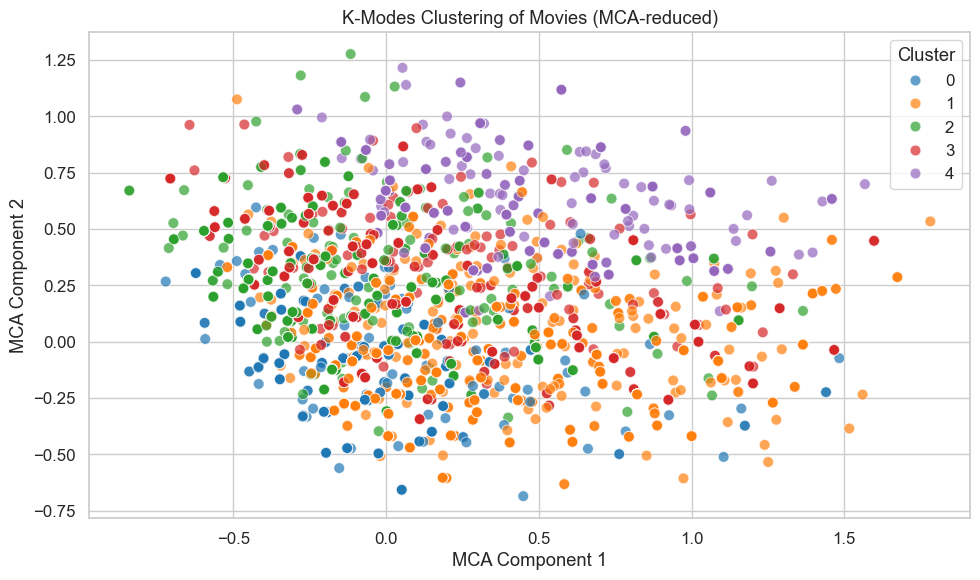

In [13]:
# Install the MCA package (prince)
!pip install prince

# Import MCA from prince
import prince
import matplotlib.pyplot as plt
import seaborn as sns


# Visualize Clusters using MCA


# Re-apply MCA to the feature space (X)
# NOTE: X is one-hot encoded genre data
mca = prince.MCA(n_components=2, random_state=42)
mca_coords = mca.fit_transform(X)

# Add MCA components and cluster labels to a new DataFrame
mca_df = mca_coords.copy()
mca_df['Cluster'] = movies_with_titles['Cluster']

# Plot clusters in 2D MCA space
plt.figure(figsize=(10, 6))
sns.scatterplot(data=mca_df, x=0, y=1, hue='Cluster', palette='tab10', s=60, alpha=0.7)
plt.title('K-Modes Clustering of Movies (MCA-reduced)')
plt.xlabel('MCA Component 1')
plt.ylabel('MCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Group genres by movieId (ignore clusters for now)
genre_transactions = movies_expanded.groupby('movieId')['genres'].apply(list).tolist()

# Encode transactions
te = TransactionEncoder()
genre_matrix = te.fit(genre_transactions).transform(genre_transactions)
df_genres = pd.DataFrame(genre_matrix, columns=te.columns_)

# Apply Apriori with low support (0.05 = 5%)
frequent_genres = apriori(df_genres, min_support=0.05, use_colnames=True)
rules_genres = association_rules(frequent_genres, metric='lift', min_threshold=1.0)

# Show top rules
print("Top Association Rules (Genres):\n")
print(rules_genres[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))


Top Association Rules (Genres):

   antecedents  consequents   support  confidence      lift
0  (Adventure)     (Action)  0.062615    0.482977  2.573940
1     (Action)  (Adventure)  0.062615    0.333698  2.573940
2   (Thriller)     (Action)  0.067235    0.345829  1.843034
3     (Action)   (Thriller)  0.067235    0.358315  1.843034
4    (Romance)     (Comedy)  0.090741    0.553885  1.436620
5     (Comedy)    (Romance)  0.090741    0.235357  1.436620
6      (Drama)      (Crime)  0.065387    0.146067  1.186813
7      (Crime)      (Drama)  0.065387    0.531276  1.186813
8   (Thriller)      (Crime)  0.058407    0.300422  2.440963
9      (Crime)   (Thriller)  0.058407    0.474562  2.440963


In [15]:
def recommend_by_genre_rules(input_genres, rules_df, top_n=5):
    input_set = set(input_genres)
    recommendations = []

    for _, row in rules_df.iterrows():
        if row['antecedents'].issubset(input_set):
            recommendations.append((row['consequents'], row['lift']))

    # Sort by lift
    recommendations = sorted(recommendations, key=lambda x: -x[1])

    # Flatten and deduplicate
    result = []
    seen = set()
    for cons, _ in recommendations:
        for genre in cons:
            if genre not in seen:
                result.append(genre)
                seen.add(genre)
            if len(result) >= top_n:
                break
        if len(result) >= top_n:
            break

    return result

# Example: Recommend genres similar to 'Comedy' and 'Romance'
recommend_by_genre_rules(['Comedy', 'Romance'], rules_genres)


['Comedy', 'Romance', 'Drama']

In [16]:
# Save association rules
rules_genres.to_csv('genre_association_rules.csv', index=False)

# Save cluster assignments
movies_with_titles.to_csv('kmodes_clustered_movies.csv', index=False)

# Save genre transactions
df_genres.to_csv('genre_transactions.csv', index=False)
